# [2-BENCHMARK] - Phase de sélection des modèles

## Import des modules
> cf. [pyproject.toml](pyproject.toml) pour connaître les librairies à installer

In [1]:
import os
import io
import json
import boto3
import joblib
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Récupération des données dans le stockage objet AWS S3

In [2]:
# Configutations S3 access and data
load_dotenv()
aws_access_key_id = os.getenv('aws_access_key_id')
aws_secret_access_key = os.getenv('aws_secret_access_key')

In [3]:
# Specific bucket data
bucket_name = "hotel-resa-prediction"
prefix = "datasets/"
filename = "processed_hotel_bookings.csv"

In [4]:
# S3 connection
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
)

In [5]:
# get datas 
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        data = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
data.head().T

,0,1,2,3,4
lead_time,342,737,7,13,14
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0.0,0.0,0.0,0.0,0.0
babies,0,0,0,0,0
previous_cancellations,0,0,0,0,0
previous_bookings_not_canceled,0,0,0,0,0
booking_changes,3,4,0,0,0
adr,0.0,0.0,75.0,75.0,98.0


## Découpe des données en train et test

**Info :** Nous allons séparer les données en variable à expliquer (target) y et en variable expliquer (features).

In [7]:
X = data.drop("is_canceled",  axis=1)
y = data["is_canceled"]
print("Features : ", X.shape)
print("Target : ", y.shape) # s'assurer de n'avoir qu'une colonne ici

Features :  (119210, 30)
Target :  (119210,)


**Info** : Pour l'apprentissage, nous avons besoin de séparer en deux partie, un jeu d'entraînement et un jeu de test. Nous faisons le choix de découper en 70/30 soit 70 en jeu d'entraînement et 30 en jeu de test. Ici, nous faisons le choix de ne par garder de dépendance temporelle c'est la raison pour laquelle on a mélanger le jeux de données avec la méthode shuffle.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    shuffle=True, 
    stratify=y # important pour bien balancer les prédictions
)
print("Features train : ", X_train.shape)
print("Target train : ", y_train.shape)
print("Features test : ", X_test.shape)
print("Target test : ", y_test.shape)

Features train :  (83447, 30)
Target train :  (83447,)
Features test :  (35763, 30)
Target test :  (35763,)


In [9]:
# Pour voir la distribution dans y_train
print("Distribution y_train:")
print(y_train.value_counts())
print("\nPourcentages y_train:")
print(y_train.value_counts(normalize=True) * 100)

# Pour voir la distribution dans y_test
print("\nDistribution y_test:")
print(y_test.value_counts())
print("\nPourcentages y_test:")
print(y_test.value_counts(normalize=True) * 100)

# Pour voir la distribution dans le dataset complet
print("\nDistribution dataset complet:")
print(y.value_counts())
print("\nPourcentages dataset complet:")
print(y.value_counts(normalize=True) * 100)

Distribution y_train:
is_canceled
0    52508
1    30939
Name: count, dtype: int64

Pourcentages y_train:
is_canceled
0    62.923772
1    37.076228
Name: proportion, dtype: float64

Distribution y_test:
is_canceled
0    22503
1    13260
Name: count, dtype: int64

Pourcentages y_test:
is_canceled
0    62.922574
1    37.077426
Name: proportion, dtype: float64

Distribution dataset complet:
is_canceled
0    75011
1    44199
Name: count, dtype: int64

Pourcentages dataset complet:
is_canceled
0    62.923412
1    37.076588
Name: proportion, dtype: float64


In [10]:
categorical_data = selector(dtype_include=object)
numerical_data = selector(dtype_exclude=object)

In [11]:
n_categorical = categorical_data(X)
n_numerical = numerical_data(X)

In [12]:
print(f"Categorial : {len(n_categorical)}")
print(f"Numerical : {len(n_numerical)}")

Categorial : 15
Numerical : 15


In [13]:
numeric_preprocessor = StandardScaler()
categoric_preprocessor = OneHotEncoder(
    handle_unknown='ignore'
)

In [14]:
preprocessor = ColumnTransformer(
    [
        ("numerical", numeric_preprocessor, n_numerical),
        ("Categorical", categoric_preprocessor, n_categorical)
    ],
    remainder = "passthrough",
)
preprocessor

,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [15]:
model_linear = LogisticRegression() 

In [16]:
model_tree = DecisionTreeClassifier() 

In [17]:
model_ensemble = RandomForestClassifier() 

In [18]:
linear_pipeline = make_pipeline(
    preprocessor,
    model_linear
)
linear_pipeline

,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
tree_pipeline = make_pipeline(
    preprocessor,
    model_tree
)
tree_pipeline

,steps,"[('columntransformer', ...), ('decisiontreeclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
ensemble_pipeline = make_pipeline(
    preprocessor,
    model_ensemble
)
ensemble_pipeline

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [21]:
cv_linear = cross_validate(
    linear_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_linear = pd.DataFrame(cv_linear)

/Users/mandresyandri/Library/Caches/pypoetry/virtualenvs/model-build-Uli2Bxu9-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mandresyandri/Library/Caches/pypoetry/virtualenvs/model-build-Uli2Bxu9-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (m

In [22]:
cv_tree = cross_validate(
    tree_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_tree = pd.DataFrame(cv_tree)

In [23]:
cv_ensemble = cross_validate(
    ensemble_pipeline,
    X_train,
    y_train,
    cv=10,
    error_score='raise',
    scoring='accuracy',
    n_jobs=-1
)
cv_ensemble = pd.DataFrame(cv_ensemble)

In [24]:
linear_scores = -cv_linear["test_score"] * 100
tree_scores = -cv_tree["test_score"] * 100
ensemble_scores = -cv_ensemble["test_score"] * 100

In [25]:
indices = np.arange(len(cv_linear)) 

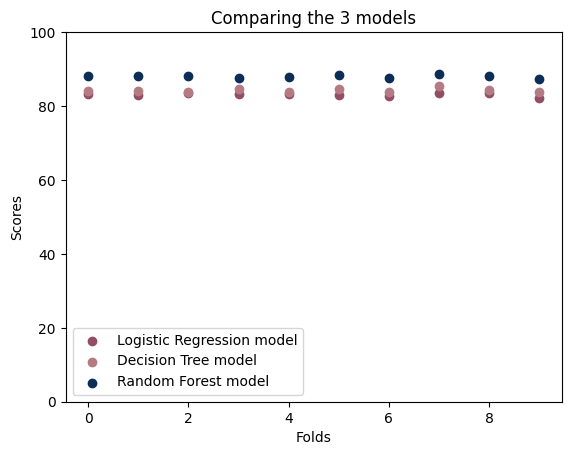

In [26]:
plt.scatter(
    indices,
    -linear_scores,
    color="#944E63",
    label="Logistic Regression model"
)

plt.scatter(
    indices,
    -tree_scores,
    color="#B47B84",
    label="Decision Tree model"
)

plt.scatter(
    indices,
    -ensemble_scores,
    color="#0C2D57",
    label="Random Forest model"
)

plt.ylim((0,100))
plt.legend()
plt.xlabel("Folds")
plt.ylabel("Scores")
_ = plt.title("Comparing the 3 models")

In [27]:
model_scores = {
    "Logistic Regression": -linear_scores.mean(),
    "Decision Tree Model": -tree_scores.mean(),
    "Random Forest": -ensemble_scores.mean()
}

In [28]:
highest_score = max(model_scores.values())

In [29]:
best_models = [model for model, score in model_scores.items() if score == highest_score] 

In [30]:
if len(best_models) == 1:
    print(f"The model with the highest accuracy score ({highest_score:.2f}%) is: {best_models[0]}")
else:
    print(f"Models with the highest accuracy score ({highest_score:.2f}%) are:")
    for model in best_models:
        print(f"\t- {model}")

The model with the highest accuracy score (87.98%) is: Random Forest


In [31]:
linear_pipeline.fit(X_train, y_train)
tree_pipeline.fit(X_train, y_train)
ensemble_pipeline.fit(X_train, y_train)

/Users/mandresyandri/Library/Caches/pypoetry/virtualenvs/model-build-Uli2Bxu9-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = linear_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, linear_pipeline.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0      0.839     0.908     0.872     22503
           1      0.819     0.705     0.757     13260

    accuracy                          0.833     35763
   macro avg      0.829     0.806     0.815     35763
weighted avg      0.832     0.833     0.830     35763

ROC-AUC: 0.9081911635847582


In [33]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = tree_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, tree_pipeline.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0      0.880     0.878     0.879     22503
           1      0.794     0.796     0.795     13260

    accuracy                          0.848     35763
   macro avg      0.837     0.837     0.837     35763
weighted avg      0.848     0.848     0.848     35763

ROC-AUC: 0.8390624638685681


In [34]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = ensemble_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_pipeline.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0      0.880     0.943     0.911     22503
           1      0.890     0.782     0.832     13260

    accuracy                          0.883     35763
   macro avg      0.885     0.862     0.871     35763
weighted avg      0.884     0.883     0.882     35763

ROC-AUC: 0.949355654875311
